## Used to create clusters of the vectorized data. 
* currently using good old k-means
* to visualize, we projected the data on 2d using PCA
* inspired by http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)


In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.externals import joblib


plt.rcParams['figure.figsize'] = (15.0, 15.0)


In [5]:
clustering_columns = [
    'ALSFRS_Total_last',
    'ALSFRS_Total_mean_slope',
    'weight_mean', 
    'weight_pct_diff',
    'Age_last',
    
    'onset_delta_last',
    'Albumin_last',
    'Creatinine_last',
    'fvc_percent_pct_diff',
    'bp_systolic_mean',
        
]


## Visualize results on PCA-reduced data

In [6]:

def visualize_kmeans(kmeans, data, resolution = 100):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
    y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()
    
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, s=10, edgecolor='none', cmap='Paired')
    # Plot the centroids as Xs
    centroids = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                c=range(len(centroids)), zorder=10, cmap='Paired')
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with crosses')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.figure(figsize=(40,40))
    plt.show()



In [7]:
proact_train = pd.read_csv('../train_data_vectorized.csv', sep = '|', index_col = 'SubjectID', dtype='float')
proact_train = proact_train[clustering_columns]
proact_train.head()

,ALSFRS_Total_last,ALSFRS_Total_mean_slope,weight_mean,weight_pct_diff,Age_last,onset_delta_last,Albumin_last,Creatinine_last,fvc_percent_pct_diff,bp_systolic_mean
SubjectID,,,,,,,,,,
533,-0.118551,-1.481164,-1.620202,-0.232289,0.941297,-0.807761,-1.192056,0.563661,-1.864018,0.725671
649,1.079381,0.011470,-0.086445,0.218932,-0.558473,0.824845,0.427261,-0.863703,-0.037980,0.535520
1234,-1.487615,-0.263637,1.246644,0.340632,-1.440691,-1.185990,1.074988,1.039449,0.993322,-1.633381
2492,0.052582,0.214504,0.924490,-0.047759,0.764854,0.767393,0.000000,0.087873,-0.361454,0.630595
2956,0.394848,-0.249574,-0.702551,-0.149486,0.764854,-2.591180,0.751124,-0.387915,0.661195,-0.011162


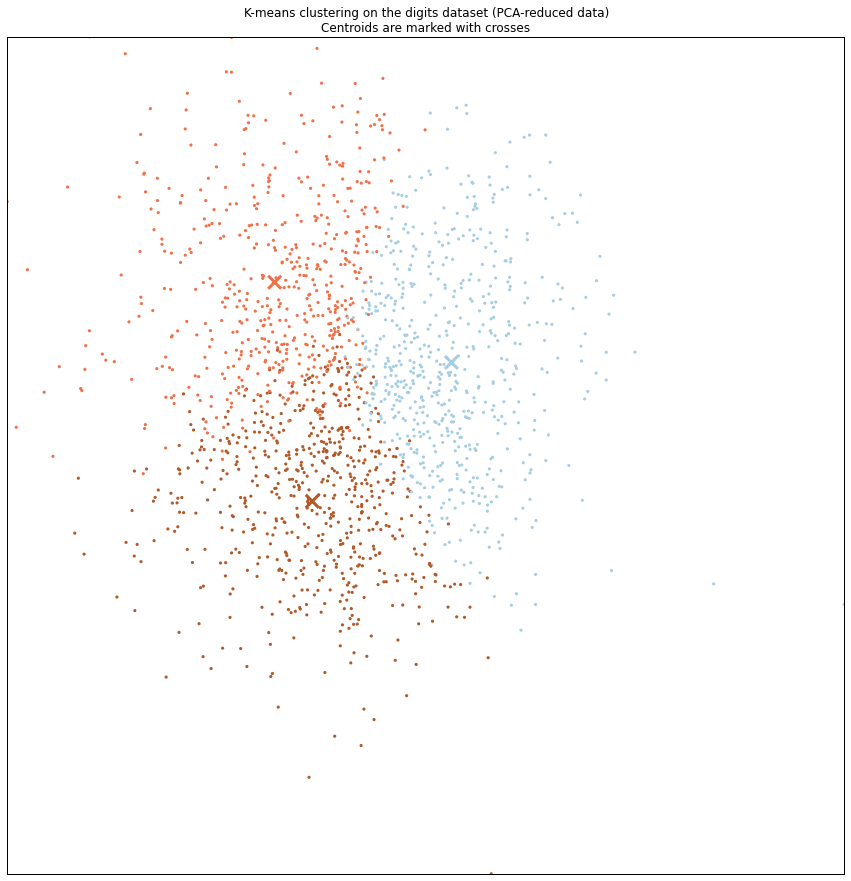

[(-3.2028760709570238e-05, 'fvc_percent_pct_diff'), (0.00040989751266331067, 'weight_pct_diff'), (0.0017584683875763818, 'onset_delta_last'), (0.0038510606653359017, 'ALSFRS_Total_mean_slope'), (0.0052388442481106443, 'weight_mean'), (0.014158146483807324, 'bp_systolic_mean'), (0.026371645959119141, 'Albumin_last'), (0.034047073488280739, 'Creatinine_last'), (0.066431745733414718, 'Age_last'), (0.07167706894544458, 'ALSFRS_Total_last')]
Cluster cnt:  [617 538 622]


In [8]:
kmeans = KMeans(init='k-means++', n_clusters=3)
kmeans.fit(proact_train)
visualize_kmeans(kmeans, proact_train)
print sorted([(metrics.adjusted_mutual_info_score(proact_train[col], kmeans.labels_), col) for col in proact_train.columns])
print "Cluster cnt: ", np.bincount(kmeans.labels_)

## Pickle the clustering model

In [9]:
clustering_model = {"columns": clustering_columns, "model": kmeans}
pickle.dump( clustering_model, open('../clustering_model.pickle', 'wb') )


In [12]:

for t in ['train', 'test']:
    cur_data = pd.read_csv('../' + t + '_data_vectorized.csv', sep = '|', error_bad_lines=False, index_col="SubjectID")
    cur_data = cur_data[clustering_columns]
    res = pd.DataFrame(index = cur_data.index)
    res['cluster'] = kmeans.predict(cur_data)
    print t, res.shape
    res.to_csv('../' + t + '_kmeans_clusters.csv',sep='|')

train (1777, 1)
test (600, 1)
